# MLP trained on the Fashion-MNIST dataset using Tensorflow

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard

from matplotlib import pyplot as plt
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load Fashion-MNIST

In [84]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [85]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Plot some examples

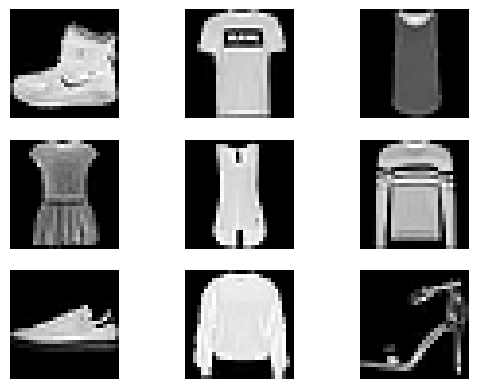

In [86]:
i = 0

for picture in x_train[:9]:
    plt.subplot(3, 3, i+1)
    plt.imshow(picture, cmap='gray')
    plt.axis('off')
    i = i + 1

plt.show()

## Create MLP

In [196]:
mlp = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

## Compile model

In [197]:
mlp.compile(
    optimizer=SGD(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Define TensorBoard callback

In [198]:
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

## Train model

In [199]:
history = mlp.fit(
    x_train,
    y_train,
    epochs=15,
    validation_split=0.2,
    batch_size=32,
    shuffle=True,
    callbacks=[tensorboard]
)

Epoch 1/15
1500/1500 [==============================] - 10s 6ms/step - loss: 1.7348 - accuracy: 0.6959 - val_loss: 0.6046 - val_accuracy: 0.7781
Epoch 2/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.6076 - accuracy: 0.7791 - val_loss: 0.5208 - val_accuracy: 0.8141
Epoch 3/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5332 - accuracy: 0.8064 - val_loss: 0.4854 - val_accuracy: 0.8275
Epoch 4/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4943 - accuracy: 0.8199 - val_loss: 0.4661 - val_accuracy: 0.8331
Epoch 5/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4649 - accuracy: 0.8284 - val_loss: 0.4505 - val_accuracy: 0.8403
Epoch 6/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4433 - accuracy: 0.8379 - val_loss: 0.4320 - val_accuracy: 0.8473
Epoch 7/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4244 - accuracy: 0.8442 - val_loss: 0.4320 - val_accuracy

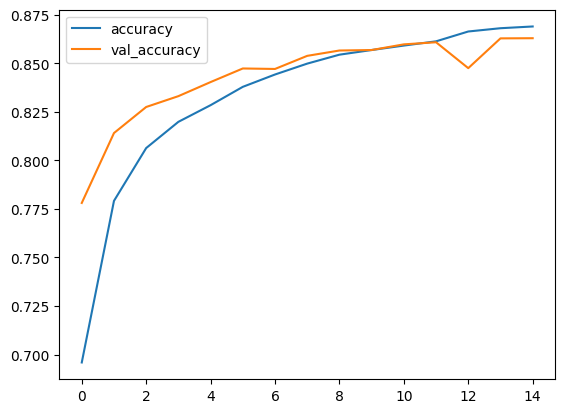

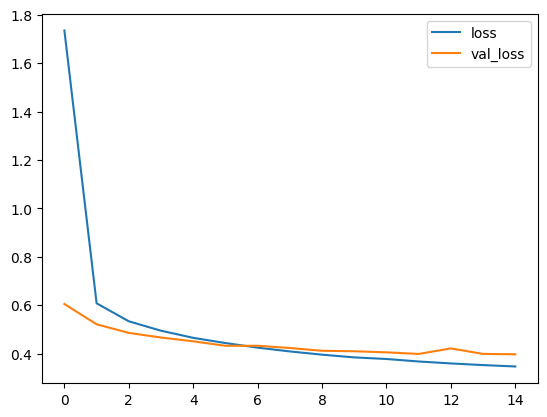

In [200]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Evaluate model

In [201]:
mlp.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4204 - accuracy: 0.8554


[0.4203624129295349, 0.855400025844574]